# Text Generation RNN

_Inspired by [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation)_

## Import dependencies

In [1]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.6.9
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Download the dataset

In [3]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

1122304/1115394 [==============================] - 0s 0us/step
/tmp/.keras/datasets/shakespeare.txt


## Analyze the dataset

In [4]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [5]:
# Take a look at the first 250 characters in text.
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [6]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Process the dataset

### Vectorize the text

In [7]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
  print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [8]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [9]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

'First Citizen:\n' --> array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0])


## Create training sequences

In [10]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [11]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
  print(index2char[char.numpy()])

F
i
r
s
t


In [12]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(index2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [0]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

In [0]:
dataset = sequences.map(split_input_target)

In [15]:
for input_example, target_example in dataset.take(1):
  print('Input:', repr(''.join(index2char[input_example.numpy()])))
  print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. 

In [16]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
  print('Step {:2d}'.format(i))
  print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
  print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 18 ('F')
  expected output: 47 ('i')
Step  1
  input: 47 ('i')
  expected output: 56 ('r')
Step  2
  input: 56 ('r')
  expected output: 57 ('s')
Step  3
  input: 57 ('s')
  expected output: 58 ('t')
Step  4
  input: 58 ('t')
  expected output: 1 (' ')


## Split training sequences into batches

In [17]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

## Build the model

In [0]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this simple example three layers are used to define our model:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions;
- [tf.keras.layers.GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU): A type of RNN with size units=rnn_units (You can also use a LSTM layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [0]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    batch_input_shape=[BATCH_SIZE, None]
))

model.add(tf.keras.layers.GRU(
    units=rnn_units,
    return_sequences=True,
    stateful=True,
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

model.add(tf.keras.layers.Dense(vocab_size))

In [44]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (64, None, 256)           16640     
_________________________________________________________________
gru_1 (GRU)                  (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


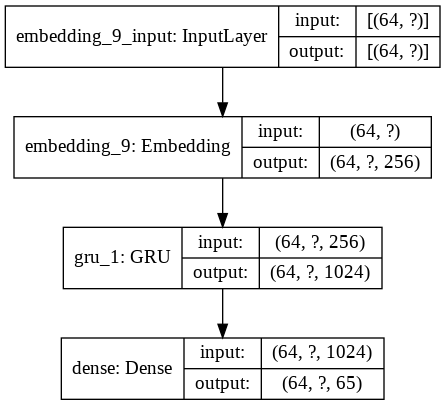

In [45]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Try the model

In [55]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 65) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [54]:
  print('Prediction for the 1st letter of the 1st sequense:')
  print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the 1st sequense:
tf.Tensor(
[-9.06651933e-03 -2.19201529e-03  1.79553516e-02 -1.51032046e-03
 -1.06607447e-04 -8.03836714e-03 -1.24467779e-02  9.77856759e-03
 -2.32896814e-03 -3.98055837e-03  7.17123458e-03 -6.43771887e-03
 -8.70024506e-03  6.99261483e-03  1.04580447e-02  4.99093439e-03
 -2.31204438e-03  1.77357113e-03 -7.83120003e-03 -2.37486847e-02
  2.62895543e-02  6.47534197e-03  2.98719038e-03  2.61819619e-03
  6.34338334e-03 -8.82999599e-03 -2.26037926e-03 -5.94630931e-03
 -1.01771939e-05 -8.75114871e-04 -7.52627989e-03  5.58725733e-04
  2.37012878e-02  7.19762081e-03  2.80855480e-03  1.97741315e-02
  1.69609413e-02 -5.13180345e-03  9.53803398e-03  1.55540975e-03
 -1.27717713e-02 -1.24683445e-02  6.85018580e-03  9.86623671e-03
 -1.28271885e-03 -1.59833487e-03  8.10914789e-04 -1.84865331e-03
  7.52026355e-03 -1.70409342e-03 -5.30830724e-03  4.07778099e-03
  1.18487477e-02 -1.39231721e-04 -1.44867348e-02  3.20840743e-03
 -1.74741284e-03 -9.69287474